In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/' 
snapshot_weights = 'models/best_weights_xy_test250_Adam_cosine.hdf5'
last_snapshot_weights = 'models/last_weights_xy_test250_Adam_cosine.hdf5'

sizex = 500
sizey = 500
sizez = 3
rand_seed = 666
num_datasets = -1
batch_size = 32
nb_epochs = 200
validation_ratio = 0.2
#ds_size = len(data_dict['y_revs'])
ds_size = 250
buf_size = ds_size

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'y' in data_dict.keys():
            #data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            #data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_nodust'].shape

(895, 500, 500, 3)

In [6]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

#coming back the mapping from 1 to 180
def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_ang'] = map_to_1(break_degeneracy(cart_to_esf(normalize(data_dict['y'], axis=1))))
data_dict['y_revs'] = esf_to_cart(map_to_180(data_dict['y_ang']))

In [7]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_norm'].shape)

(895, 3)


In [8]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
# functions to visualice the data 
def viz(img, label, pred=np.array([0,0,0]), id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if np.sum(np.abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if np.sum(np.abs(pred)) > 0: display(Markdown("#### **cartesian prediction (x_y):** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()

# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_ang: (2,), y_revs: (3,)}, types: {x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_ang: tf.float64, y_revs: tf.float64}>


#### **cartesian label:** [ 0.32824791 -0.93567687  0.12946857]

#### **cartesian prediction (x_y):** [-0.32824791  0.93567687  0.12946857]

#### **ID:** b'g1.92e12_x191_y196_z346'

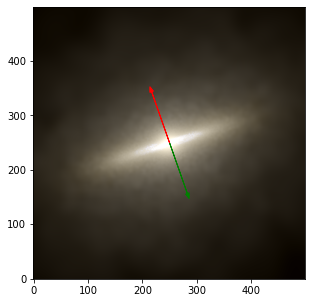

#### **cartesian label:** [ 0.69888396 -0.48242208  0.5280437 ]

#### **cartesian prediction (x_y):** [-0.69888396  0.48242208  0.5280437 ]

#### **ID:** b'g4.94e10_x95_y40_z353'

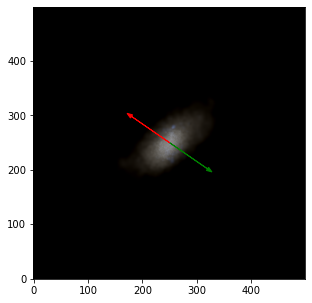

#### **cartesian label:** [ 0.32748777 -0.90499277  0.27155083]

#### **cartesian prediction (x_y):** [-0.32748777  0.90499277  0.27155083]

#### **ID:** b'g2.57e11_x169_y353_z23'

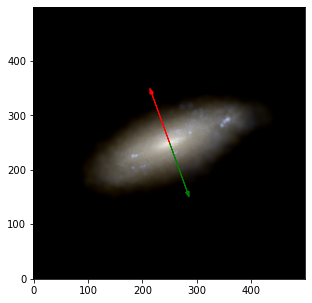

#### **cartesian label:** [ 0.529758   -0.33886048  0.7775153 ]

#### **cartesian prediction (x_y):** [-0.529758    0.33886048  0.7775153 ]

#### **ID:** b'g1.50e10_x295_y296_z33'

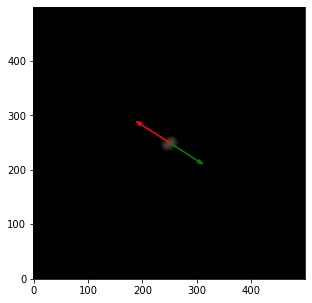

#### **cartesian label:** [ 0.93311959 -0.07987218 -0.35058276]

#### **cartesian prediction (x_y):** [-0.93311959  0.07987218 -0.35058276]

#### **ID:** b'g4.99e09_x292_y197_z332'

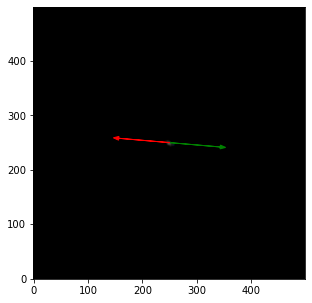

#### **cartesian label:** [ 0.7952049  -0.15544084  0.5860779 ]

#### **cartesian prediction (x_y):** [-0.7952049   0.15544084  0.5860779 ]

#### **ID:** b'g1.12e12_x324_y109_z175'

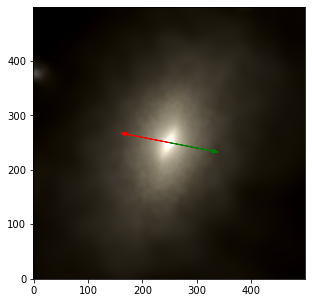

#### **cartesian label:** [-0.23745501 -0.33004524 -0.91361111]

#### **cartesian prediction (x_y):** [ 0.23745501  0.33004524 -0.91361111]

#### **ID:** b'g3.67e09_x320_y258_z122'

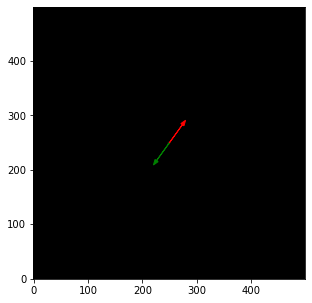

#### **cartesian label:** [-0.46789934 -0.02189159  0.88351059]

#### **cartesian prediction (x_y):** [0.46789934 0.02189159 0.88351059]

#### **ID:** b'g1.50e10_x158_y72_z172'

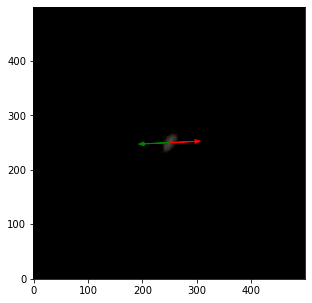

#### **cartesian label:** [0.66018449 0.69187025 0.29235593]

#### **cartesian prediction (x_y):** [0.66018449 0.69187025 0.29235593]

#### **ID:** b'g1.95e10_x123_y47_z338'

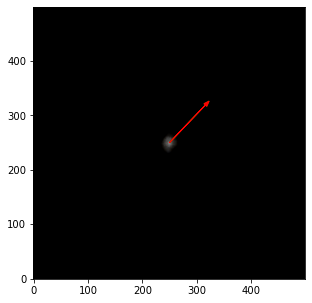

#### **cartesian label:** [-0.36234559 -0.68405446  0.63306806]

#### **cartesian prediction (x_y):** [0.36234559 0.68405446 0.63306806]

#### **ID:** b'g4.99e09_x62_y80_z230'

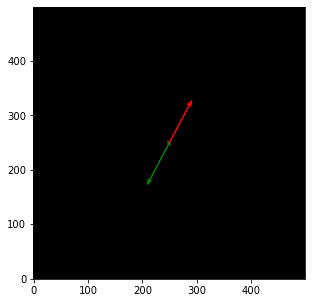

In [10]:
# visualice the data
real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,5):
    elements = real_dataset.take(idx)
    for elem in elements:
        viz(elem['x_nodust'][idx], elem['y_norm'][idx], elem['y_revs'][idx], id=elem['ids'][idx])

In [11]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

input_ds = input_ds.take(ds_size)
val_size = math.floor(ds_size * validation_ratio)

validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [12]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

In [13]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), include_top=False)

# redefine the output to be 2 parameters from the last dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation=None)(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
if os.path.isfile(last_snapshot_weights):
    print('loaded weights')
    model.load_weights(last_snapshot_weights)
    
cossim = lambda y, p_y: -1*tf.keras.backend.abs(tf.keras.losses.cosine_similarity(y, p_y))
model.compile(optimizer= 'Adam', loss=cossim, metrics=[
                        tf.keras.metrics.mean_squared_error, 
                        tf.keras.metrics.mean_absolute_error, 
                        tf.keras.metrics.mean_absolute_percentage_error])

In [14]:
# model.summary()

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='mean_absolute_error',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='mean_absolute_error',
                               verbose=1,
                               save_best_only=False)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2
]


model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: -0.6565 - mean_squared_error: 23.6214 - mean_absolute_error: 2.8660 - mean_absolute_percentage_error: 1337.1322
Epoch 00001: mean_absolute_error improved from inf to 2.86601, saving model to models/best_weights_xy_test250_Adam_cosine.hdf5

Epoch 00001: saving model to models/last_weights_xy_test250_Adam_cosine.hdf5
7/7 [==============================] - 54s 8s/step - loss: -0.6565 - mean_squared_error: 23.6214 - mean_absolute_error: 2.8660 - mean_absolute_percentage_error: 1337.1322 - val_loss: -0.7386 - val_mean_squared_error: 23416350441472.0000 - val_mean_absolute_error: 2550280.0000 - val_mean_absolute_percentage_error: 1617187328.0000
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: -0.6811 - mean_squared_error: 16.4317 - mean_absolute_error: 2.5384 - mean_absolute_percentage_error: 1024.0944
Epoch 00002: mean_absolute_error improved from 2.86601 to 2.53842, saving model to models/best_weights_xy_

In [15]:
model.save('models/trained_xy_test250_Adam_cosine.h5')

In [16]:
# taking samples from the validation dataset and evaluating the model
val_ex, = validation_ds.take(1)
images, labels = val_ex[0], val_ex[1]
outputs = model.predict(images)

In [17]:
#print(labels)
print(outputs[:20])

[[-4.3172226   7.267375  ]
 [-0.56550455 -1.6180037 ]
 [-1.5680813   6.152943  ]
 [-2.860368   -0.65238804]
 [-4.0351353   0.604696  ]
 [-6.3931007   2.6165793 ]
 [-0.39760515 -2.5384045 ]
 [-7.902691   -2.8033402 ]
 [-0.6408318  -1.399646  ]
 [-5.083953    4.7264533 ]
 [-3.5363226  -2.610997  ]
 [-6.510363   -0.19779688]
 [-4.830699    3.8557763 ]
 [-5.622068    2.0952895 ]
 [-7.853214   -0.7616084 ]
 [-0.9619535  -1.5826341 ]
 [-1.0343636   5.5847273 ]
 [-2.0130157   3.3480933 ]
 [-0.9789721   5.051555  ]
 [-0.0472666   5.350229  ]]


#### **cartesian label:** [-0.79476786 -0.02821311]

#### **cartesian prediction (x_y):** [-4.3172226  7.267375 ]

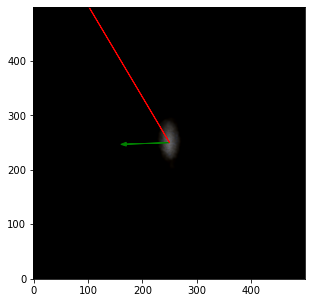

#### **cartesian label:** [0.16465198 0.43273833]

#### **cartesian prediction (x_y):** [-0.56550455 -1.6180037 ]

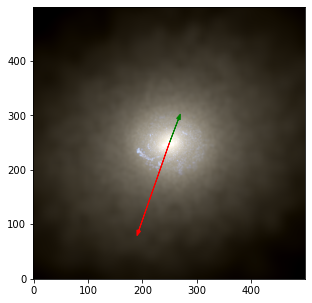

#### **cartesian label:** [-0.28957403 -0.83786666]

#### **cartesian prediction (x_y):** [-1.5680813  6.152943 ]

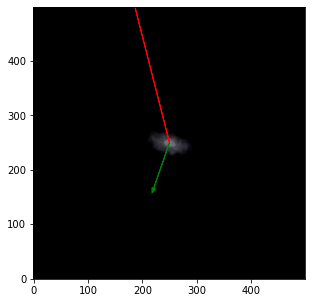

#### **cartesian label:** [-0.44929716 -0.14011286]

#### **cartesian prediction (x_y):** [-2.860368   -0.65238804]

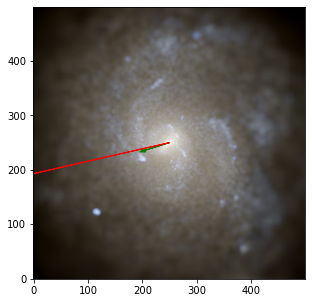

#### **cartesian label:** [-0.65529716 -0.01885475]

#### **cartesian prediction (x_y):** [-4.0351353  0.604696 ]

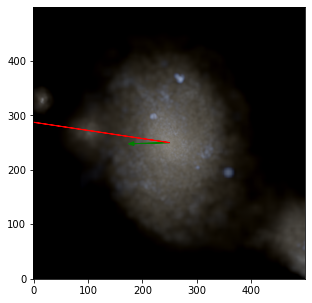

#### **cartesian label:** [ 0.8984316  -0.02597428]

#### **cartesian prediction (x_y):** [-6.3931007  2.6165793]

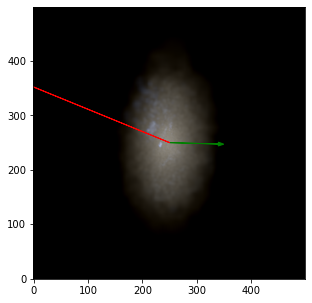

#### **cartesian label:** [-0.5323512  0.3204348]

#### **cartesian prediction (x_y):** [-0.39760515 -2.5384045 ]

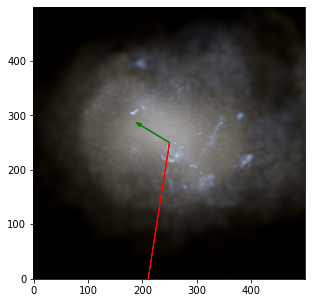

#### **cartesian label:** [0.912262   0.07897478]

#### **cartesian prediction (x_y):** [-7.902691  -2.8033402]

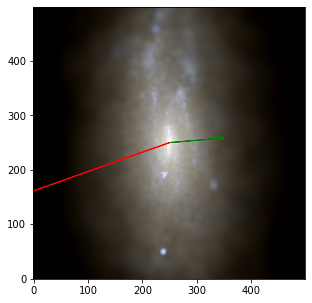

#### **cartesian label:** [-0.582031  -0.7110629]

#### **cartesian prediction (x_y):** [-0.6408318 -1.399646 ]

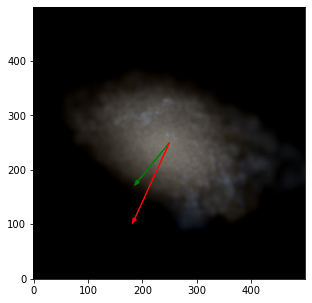

#### **cartesian label:** [-0.994252   -0.01286145]

#### **cartesian prediction (x_y):** [-5.083953   4.7264533]

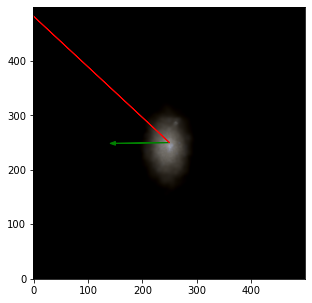

#### **cartesian label:** [-0.6349558 -0.7693941]

#### **cartesian prediction (x_y):** [-3.5363226 -2.610997 ]

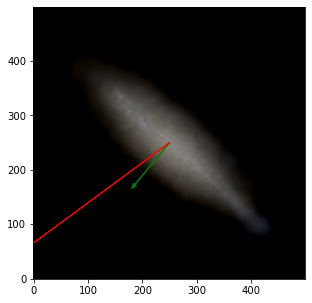

#### **cartesian label:** [0.50448936 0.49755648]

#### **cartesian prediction (x_y):** [-6.510363   -0.19779688]

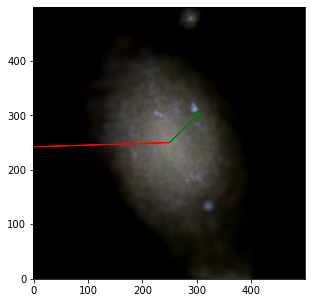

#### **cartesian label:** [ 0.70934874 -0.4818626 ]

#### **cartesian prediction (x_y):** [-4.830699   3.8557763]

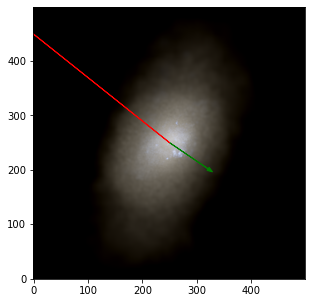

#### **cartesian label:** [ 0.6877297  -0.16112445]

#### **cartesian prediction (x_y):** [-5.622068   2.0952895]

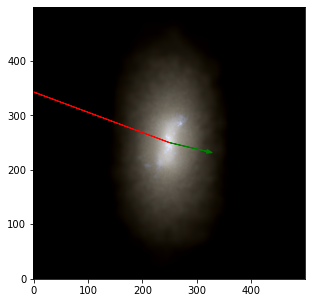

#### **cartesian label:** [0.83467937 0.37659892]

#### **cartesian prediction (x_y):** [-7.853214  -0.7616084]

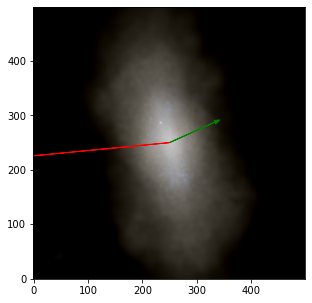

In [18]:
# visualicing the results
for img,label,pred,i in zip(images, labels, outputs,range(15)):
    viz(img, label, pred)